In [ ]:
!pip install scapy

     |████████████████████████████████| 1.1MB 30.7MB/s 
  Created wheel for scapy: filename=scapy-2.4.5-py2.py3-none-any.whl size=1261554 sha256=5c843899aaffce8dc00d70c86bc1881b25134c40fea241812210485774986c25
  Stored in directory: /root/.cache/pip/wheels/31/80/dc/d5fc39b70e1af4f4636356c849de414a76e83a89d8ee9cd78f
Successfully built scapy


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
% cd Code/kitNet
% ls

[Errno 2] No such file or directory: 'Code/kitNet'
/content/drive/MyDrive/BTP/BTP/Code
'Autoencoder Based'/   eemd_example.png   Kittu.ipynb                train1.csv
'BrokenTooth Data'/    fft.png            __pycache__/               train2.csv
 code2.py             'Healthy Data'/     SupervisedBaseline.ipynb
 code.py               KitNET/           'SVM Based'/
 Data/                 Kitsune.py         test.png


In [ ]:
!pip install kitnet


ERROR: Could not find a version that satisfies the requirement kitnet (from versions: none)
ERROR: No matching distribution found for kitnet


In [ ]:
from KitNET.KitNET import KitNET
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft
from scipy.stats import ttest_ind

class Kitsune:
    def __init__(self, NumFeatures = 4, max_autoencoder_size = 10, AD_grace_period = 40000, FM_grace_period = 2000, learning_rate = 0.1, hidden_ratio = 0.75):
        self.NumFeatures = NumFeatures
        self.AnomDetector = KitNET(self.NumFeatures, max_autoencoder_size, FM_grace_period, AD_grace_period, learning_rate, hidden_ratio)
        self.count = 0
        self.Adaptive_Grace = AD_grace_period + FM_grace_period
        # Flag to turn on adaptive mode
        self.ENABLE_ADAPTIVE = 0
        # Using fixed interval adaptive
        self.Adaptive_interval = 10000
        self.prevCount = 0

    def proc_next_vector(self, row):
        # Flag for determining when to start adaptive training
        if self.count > self.Adaptive_Grace and self.ENABLE_ADAPTIVE == 0:
            self.ENABLE_ADAPTIVE = 1
        
        # If row vector is empty, return invalid RMSE
        if len(row) == 0:
            return -1

        self.count += 1
        if self.count%1000 == 0:
            print(f'{self.count} records processed')
        # process KitNET
        self.rmse = self.AnomDetector.process(row)

        # If Adaptive is enabled, we introduce periodic retraining
        if self.ENABLE_ADAPTIVE and self.count - self.prevCount > self.Adaptive_interval and self.rmse < 0.75:
            # Implemented hard thresholding right now
            # Have to replace it by auto one
            self.prevCount = self.count
            self.AnomDetector.train(row)
        # Calculating stats
        # self.rmse_var = ((self.rmse_var * self.rmse_mean)**2 * self.counter + self.rmse * self.rmse) / (self.counter + 1)
        # self.rmse_mean = (self.counter * self.rmse_mean + self.rmse) / (self.counter + 1)
        # self.rmse_var -= self.rmse_mean**2
        # alert = 0
        # if self.counter > self.Z_Grace:
        #     zval = (self.rmse - self.rmse_mean) / math.sqrt(self.rmse_var + 1)
        #     if zval > self.zscore or zval < -self.zscore:
        #         alert = 1
        return self.rmse

In [ ]:
path = './Healthy Data/h30hz0.txt'
df = pd.read_csv(path, sep='\t', names=['acc1', 'acc2', 'acc3', 'acc4', 'acc5'], header=None)
df.head()

,acc1,acc2,acc3,acc4,acc5
0,4.636710,0.516978,-3.205940,1.82241,NaN
1,1.992800,4.184660,-2.740610,2.80436,NaN
2,-3.764110,0.997335,-1.303090,1.83668,NaN
3,-4.558710,6.104330,-1.720690,1.72311,NaN
4,0.575382,0.170980,-0.497967,-1.32895,NaN


Feature-Mapper: train-mode, Anomaly-Detector: off-mode
1000 records processed
2000 records processed
The Feature-Mapper found a mapping: 4 features to 1 autoencoders.
Feature-Mapper: execute-mode, Anomaly-Detector: train-mode
3000 records processed
4000 records processed
5000 records processed
6000 records processed
7000 records processed
8000 records processed
9000 records processed
10000 records processed
11000 records processed
12000 records processed
13000 records processed
14000 records processed
15000 records processed
16000 records processed
17000 records processed
18000 records processed
19000 records processed
20000 records processed
21000 records processed
22000 records processed
23000 records processed
24000 records processed
25000 records processed
26000 records processed
27000 records processed
28000 records processed
29000 records processed
30000 records processed
31000 records processed
32000 records processed
33000 records processed
34000 records processed
35000 records

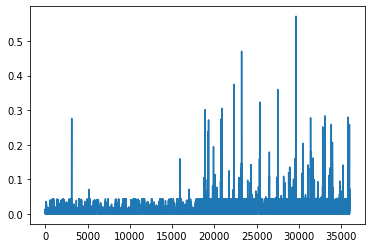

In [ ]:
%matplotlib inline
RMSE = []
path = './Healthy Data/h30hz0.txt'
df = pd.read_csv(path, sep='\t', names=['acc1', 'acc2', 'acc3', 'acc4', 'acc5'], header=None)
cols = ['acc1', 'acc2', 'acc3', 'acc4']
df = df[cols]
df = df[:60000]
df = pd.DataFrame(np.abs(fft(df)), columns=cols)
clasifier = Kitsune()

for i in range(len(df)):
    RMSE.append(clasifier.proc_next_vector(df.iloc[i]))

b_RMSE = []

print('Broken Tooth')
path = './BrokenTooth Data/b30hz0.txt'
df = pd.read_csv(path, sep='\t', names=['acc1', 'acc2', 'acc3', 'acc4', 'acc5'], header=None)
cols = ['acc1', 'acc2', 'acc3', 'acc4']
df = df[cols]
df = df[:18000]
df = df[:18000]
df = np.abs(fft(df))
df = pd.DataFrame(np.abs(fft(df)), columns=cols)
for i in range(len(df)):
    b_RMSE.append(clasifier.proc_next_vector(df.iloc[i]))

t, p = ttest_ind(RMSE, b_RMSE, equal_var=False)
print(t, p)

x = RMSE[42000:] + b_RMSE
plt.plot(x)
plt.savefig('test.png')

In [1]:
df

NameError: ignored

In [ ]:
t, p = ttest_ind(RMSE, RMSE[300:], equal_var=False)
print(t,p)

-0.4014600483737795 0.6880821634118743


In [ ]:
c_RMSE = []
path = './BrokenTooth Data/b30hz50.txt'
df = pd.read_csv(path, sep='\t', names=['acc1', 'acc2', 'acc3', 'acc4', 'acc5'], header=None)
cols = ['acc1', 'acc2', 'acc3', 'acc4']
df = df[cols]
df = df[:18000]
df = df[:18000]
df = np.abs(fft(df))
df = pd.DataFrame(np.abs(fft(df)), columns=cols)
for i in range(len(df)):
    c_RMSE.append(clasifier.proc_next_vector(df.iloc[i]))

t, p = ttest_ind(RMSE, c_RMSE, equal_var=False)
print(t, p)

79000 records processed
80000 records processed
81000 records processed
82000 records processed
83000 records processed
84000 records processed
85000 records processed
86000 records processed
87000 records processed
88000 records processed
89000 records processed
90000 records processed
91000 records processed
92000 records processed
93000 records processed
94000 records processed
95000 records processed
96000 records processed
-58.7553207765409 0.0


In [ ]:
c_RMSE = []
path = './Healthy Data/h30hz50.txt'
df = pd.read_csv(path, sep='\t', names=['acc1', 'acc2', 'acc3', 'acc4', 'acc5'], header=None)
cols = ['acc1', 'acc2', 'acc3', 'acc4']
df = df[cols]
df = df[:18000]
df = df[:18000]
df = np.abs(fft(df))
df = pd.DataFrame(np.abs(fft(df)), columns=cols)
for i in range(len(df)):
    c_RMSE.append(clasifier.proc_next_vector(df.iloc[i]))

t, p = ttest_ind(RMSE, c_RMSE, equal_var=False)
print(t, p)

97000 records processed
98000 records processed
99000 records processed
100000 records processed
101000 records processed
102000 records processed
103000 records processed
104000 records processed
105000 records processed
106000 records processed
107000 records processed
108000 records processed
109000 records processed
110000 records processed
111000 records processed
112000 records processed
113000 records processed
114000 records processed
-48.150016896472195 0.0


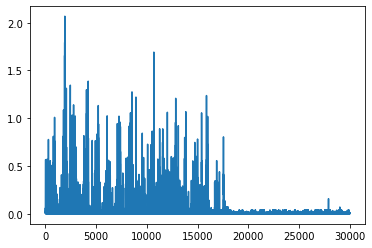

In [ ]:
plt.plot(c_RMSE + RMSE[48000:])